In [223]:
import numpy as np
from scipy.spatial import transform
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import collimator
from collimator import library
from collimator.backend import io_callback

# If needed, enable offscreen rendering (eg. for CI)
# import os
# os.environ['MUJOCO_GL'] = 'egl'

import mujoco
import mediapy

18:19:47.310 - [collimator][INFO]: Initialized MuJoCo from model file '/home/carter/bimanual-franka-main/resources/bi-franka/scene.xml' with dt=0.01, 32 generalized positions, 30 generalized velocities, and 0 actuators. The default control input vector (nu=8) is:
np.array([0.0, 0.0, 0.0, -1.5708, 0.0, 1.5708, -0.7853, 255.0]) at: MuJoCo_367_ 


""

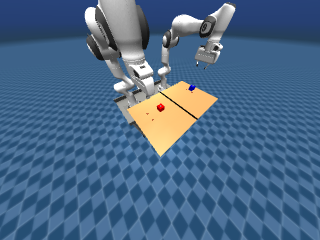

In [224]:
mjmodel = library.mujoco.MuJoCo(
    file_name="/home/carter/bimanual-franka-main/resources/bi-franka/scene.xml",
    enable_video_output=True,
    key_frame_0="home"
)

frame = mjmodel.render()

mediapy.show_image(frame)

In [ ]:
model = mujoco.MjModel.from_xml_path("/home/carter/bimanual-franka-main/resources/bi-franka/scene.xml")

hand_id = model.body("fa-hand").id  # The end effector ID
target_id = model.site("target_left").id  # The block ("target") ID

# Actuators for controlled joints
arm_actuator_names = [
    "fa-actuator1",
    "fa-actuator2",
    "fa-actuator3",
    "fa-actuator4",
    "fa-actuator5",
    "fa-actuator6",
    "fa-actuator7"
]

left_arm_actuator_names = [
    "fa-actuator1",
    "fa-actuator2",
    "fa-actuator3",
    "fa-actuator4",
    "fa-actuator5",
    "fa-actuator6",
    "fa-actuator7"
]

right_arm_actuator_names = [
    "fb-actuator1",
    "fb-actuator2",
    "fb-actuator3",
    "fb-actuator4",
    "fb-actuator5",
    "fb-actuator6",
    "fb-actuator7"
]
arm_actuator_ids = np.array([model.actuator(name).id for name in arm_actuator_names])
grip_actuator_id = model.actuator("fa-actuator8").id  # Tendon for the end-effector gripper

left_grip_actuator_id = model.actuator("fa-actuator8").id  # Tendon for the end-effector gripper
# right_grip_actuator_id = model.actuator("fb-actuator8").id  # Tendon for the end-effector gripper


# Describes the ids for the left and right arms
left_arm_actuator_ids = np.array([model.actuator(name).id for name in left_arm_actuator_names])
# right_arm_actuator_ids = np.array([model.actuator(name).id for name in right_arm_actuator_names])

In [226]:
dt = 0.001

jac_buffer = np.zeros((6, model.nv))
def jac_script(model, data):
    mujoco.mj_jacBody(model, data, jac_buffer[:3], jac_buffer[3:], hand_id)
    return jac_buffer

custom_outputs = {
    "hand_xpos": lambda model, data: data.body(hand_id).xpos,
    "hand_xquat": lambda model, data: data.body(hand_id).xquat,
    "target_xpos": lambda model, data: data.body(target_id).xpos,
    "target_xmat": lambda model, data: data.body(target_id).xmat,
    "jac": jac_script,
}

mjmodel = library.mujoco.MuJoCo(
    file_name="/home/carter/bimanual-franka-main/resources/bi-franka/scene.xml",
    dt=dt,
    key_frame_0="home",
    enable_video_output=True,
    custom_output_scripts=custom_outputs,
)
data = mjmodel._data

18:19:47.812 - [collimator][INFO]: Initialized MuJoCo from model file '/home/carter/bimanual-franka-main/resources/bi-franka/scene.xml' with dt=0.001, 32 generalized positions, 30 generalized velocities, and 0 actuators. The default control input vector (nu=8) is:
np.array([0.0, 0.0, 0.0, -1.5708, 0.0, 1.5708, -0.7853, 255.0]) at: MuJoCo_368_ 


In [227]:
dt = 0.001

jac_buffer = np.zeros((6, model.nv))
def jac_script(model, data):
    mujoco.mj_jacBody(model, data, jac_buffer[:3], jac_buffer[3:], hand_id)
    return jac_buffer

custom_outputs = {
    "hand_xpos": lambda model, data: data.body(hand_id).xpos,
    "hand_xquat": lambda model, data: data.body(hand_id).xquat,
    "target_xpos": lambda model, data: data.body(target_id).xpos,
    "target_xmat": lambda model, data: data.body(target_id).xmat,
    "jac": jac_script,
}

mjmodel = library.mujoco.MuJoCo(
    file_name="/home/carter/bimanual-franka-main/resources/bi-franka/scene.xml",
    dt=dt,
    key_frame_0="home",
    enable_video_output=True,
    custom_output_scripts=custom_outputs,
)
data = mjmodel._data

18:19:48.201 - [collimator][INFO]: Initialized MuJoCo from model file '/home/carter/bimanual-franka-main/resources/bi-franka/scene.xml' with dt=0.001, 32 generalized positions, 30 generalized velocities, and 0 actuators. The default control input vector (nu=8) is:
np.array([0.0, 0.0, 0.0, -1.5708, 0.0, 1.5708, -0.7853, 255.0]) at: MuJoCo_369_ 


In [228]:
# Define key locations in the scene
# home_pos = data.body(hand_id).xpos.copy()
# u0 = data.ctrl[arm_actuator_ids].copy()
# target_pos = data.body(target_id).xpos.copy()
# # Approach directly above the cube
# pregrasp_pos = target_pos + np.array([0.0, 0.0, 0.10])  # 10 cm above
# grasp_pos    = target_pos + np.array([0.0, 0.0, 0.01])  # 1 cm above

# waypoint_pos = home_pos + np.array([0.1, 0.1, 0.2])  # e.g. 10cm x, 10cm y, 20cm above home
# preplace_pos = np.array([0.6, 0.35, 0.5])
# place_pos = preplace_pos + np.array([0.0, 0.0, -0.12])

# Define key locations in the scene
home_pos = data.body(hand_id).xpos.copy()
u0 = data.ctrl[arm_actuator_ids].copy()
target_pos = data.site(target_id).xpos.copy()
pregrasp_pos = target_pos + np.array([-0.01, 0.0, 0.3])
grasp_pos = target_pos + np.array([-0.01, 0.0, 0.05])
waypoint_pos = home_pos + np.array([0.0, 0.0, -0.1])
preplace_pos = np.array([0.6, 0.35, 0.5])
place_pos = preplace_pos + np.array([0.0, 0.0, -0.12])

In [229]:
# Custom block to output piecewise linear target locations
OPEN = np.array(0)
CLOSE = np.array(1)

# Motion stages (times are cumulative in seconds)
scale = 2.0
t0 = 0.0
time_array = np.array([
    0.0,  # Home
    2.0,  # Pre-grasp
    3.0,  # Grasp
    3.5,  # Close gripper (grasp)
    4.5,  # Pre-grasp
    7.5,  # Waypoint
    # 9.0,  # Pre-place
    # 10.0,  # Place
    # 10.5,  # Open gripper (place)
    # 11.5,  # Pre-place
    # 13.0,  # Home
]) / scale
tf = time_array[-1]

xpos_array = np.array([
    home_pos,
    pregrasp_pos,
    grasp_pos,
    grasp_pos,
    pregrasp_pos,
    waypoint_pos,
    # preplace_pos,
    # place_pos,
    # place_pos,
    # preplace_pos,
    # home_pos,
])

# vmap interpolation to allow for 2d array input
interp_fun = jax.vmap(jnp.interp, (None, None, 1))

def pos_command_cb(time):
    t = time - t0
    return jnp.where((t < 0.0) | (t > tf), home_pos, interp_fun(t, time_array, xpos_array))

def grip_command_cb(time):
    t = time - t0
    return jnp.where((t > time_array[2]) & (t < time_array[5]), 0.0, 255.0)

pos_source = library.SourceBlock(pos_command_cb, name="pos_command")
grip_source = library.SourceBlock(grip_command_cb, name="grip_command")

In [230]:
# Custom class for inverse kinematics

class InverseKinematics(collimator.LeafSystem):
    def __init__(self, nv, name="InverseKinematics"):
        super().__init__(name=name)

        # Preallocate some arrays for computing inverse kinematics
        self.error = np.zeros(6)
        self.hand_quat = np.zeros(4)
        self.hand_quat_conj = np.zeros(4)
        self.error_quat = np.zeros(4)

        # Create input ports
        self.declare_input_port("target_pos")
        self.declare_input_port("target_quat")
        self.declare_input_port("pos")
        self.declare_input_port("quat")
        self.declare_input_port("jac")

        # Output port: joint velocities
        def _output_cb(time, state, *inputs, **parameters):
            return io_callback(self._diffik, np.zeros(nv), *inputs)

        self.declare_output_port(_output_cb, period=dt)

    def _diffik(self, target_pos, target_quat, pos, quat, jac):
        # Compute the error in position and orientation
        self.error[:3] = target_pos - pos
        mujoco.mju_negQuat(self.hand_quat_conj, quat)
        mujoco.mju_mulQuat(self.error_quat, target_quat, self.hand_quat_conj)
        mujoco.mju_quat2Vel(self.error[3:], self.error_quat, 1.0)

        # Solve system of equations: J @ dq = dx
        return np.linalg.pinv(jac) @ self.error

In [231]:

builder = collimator.DiagramBuilder()
builder.add(mjmodel, grip_source, pos_source)

# Constant orientation for the end-effector
rot = transform.Rotation.from_euler("xyz", [90, 0, 180], degrees=True)
const_q0 = builder.add(library.Constant(rot.as_quat(), name="q0"))

# Inverse kinematics
ik = builder.add(InverseKinematics(nv=mjmodel.nv))
builder.connect(pos_source.output_ports[0], ik.input_ports[0])  # Target position
builder.connect(const_q0.output_ports[0], ik.input_ports[1])  # Target orientation
builder.connect(mjmodel.get_output_port("hand_xpos"), ik.input_ports[2])  # Current position
builder.connect(mjmodel.get_output_port("hand_xquat"), ik.input_ports[3])  # Current orientation
builder.connect(mjmodel.get_output_port("jac"), ik.input_ports[4])  # Jacobian

# Extract only the controlled joints from the inverse kinematics
dq_arm = builder.add(library.FeedthroughBlock(lambda dq: dq[arm_actuator_ids], name="dq_arm"))
builder.connect(ik.output_ports[0], dq_arm.input_ports[0])
demux_dq = builder.add(library.Demultiplexer(len(arm_actuator_ids), name="demux_dq"))
builder.connect(dq_arm.output_ports[0], demux_dq.input_ports[0])

# Replicate PID controllers for each joint
pid = builder.add(library.Multiplexer(len(arm_actuator_ids), name="pid"))
for i in range(len(arm_actuator_ids)):
    pid_i = builder.add(library.PIDDiscrete(kp=10, ki=1, kd=0.01, dt=dt))
    builder.connect(demux_dq.output_ports[i], pid_i.input_ports[0])
    builder.connect(pid_i.output_ports[0], pid.input_ports[i])

# Add the base control signal to the PID output
adder_uq = builder.add(library.Adder(2, name="uq"))  # Joint commands
const_uq0 = builder.add(library.Constant(mjmodel.ctrl_0[arm_actuator_ids], name="uq0"))
builder.connect(const_uq0.output_ports[0], adder_uq.input_ports[0])
builder.connect(pid.output_ports[0], adder_uq.input_ports[1])

# Append the gripper command to the joint commands
mux_u = builder.add(library.Multiplexer(2, name="u"))
builder.connect(adder_uq.output_ports[0], mux_u.input_ports[0])
builder.connect(grip_source.output_ports[0], mux_u.input_ports[1])

builder.connect(mux_u.output_ports[0], mjmodel.input_ports[0])

system = builder.build()
system.pprint()

│── root <Diagram>
    │── MuJoCo_369_ <MuJoCo> [hand_xpos → InverseKinematics.pos, hand_xquat → InverseKinematics.quat, jac → InverseKinematics.jac]
    │── grip_command <SourceBlock> [out_0 → u.in_1]
    │── pos_command <SourceBlock> [out_0 → InverseKinematics.target_pos]
    │── q0 <Constant> [out_0 → InverseKinematics.target_quat]
    │── InverseKinematics <InverseKinematics> [out_0 → dq_arm.in_0]
    │── dq_arm <FeedthroughBlock> [out_0 → demux_dq.in_0]
    │── demux_dq <Demultiplexer> [out_0 → PIDDiscrete_377_.in_0, out_1 → PIDDiscrete_378_.in_0, out_2 → PIDDiscrete_379_.in_0, out_3 → PIDDiscrete_380_.in_0, out_4 → PIDDiscrete_381_.in_0, out_5 → PIDDiscrete_382_.in_0, out_6 → PIDDiscrete_383_.in_0]
    │── pid <Multiplexer> [out_0 → uq.in_1]
    │── PIDDiscrete_377_ <PIDDiscrete> [out_0 → pid.in_0]
    │── PIDDiscrete_378_ <PIDDiscrete> [out_0 → pid.in_1]
    │── PIDDiscrete_379_ <PIDDiscrete> [out_0 → pid.in_2]
    │── PIDDiscrete_380_ <PIDDiscrete> [out_0 → pid.in_3]
    │── PI

In [232]:
context = system.create_context()

recorded_signals = {
    "qpos": mjmodel.output_ports[0],
    "pos_cmd": pos_source.output_ports[0],
    "hand_xpos": mjmodel.get_output_port("hand_xpos"),
    "target_xpos": mjmodel.get_output_port("target_xpos"),
    "target_xmat": mjmodel.get_output_port("target_xmat"),
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
) 

18:19:48.560 - [collimator][INFO]: max_major_steps=7498 based on smallest discrete period=0.001
18:19:48.561 - [collimator][INFO]: Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=7498, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=5, return_context=True), Dopri5Solver(system=Diagram(root, 18 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, max_checkpoints=16, supports_mass_matrix=False)


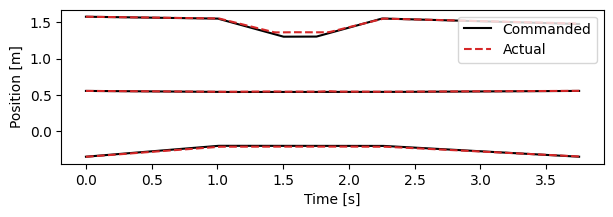

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(7, 2), sharex=True)

for i in range(3):
    ax.plot(results.time, results.outputs["pos_cmd"][:, i], c='k')
    ax.plot(results.time, results.outputs["hand_xpos"][:, i], '--', c='tab:red')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position [m]")
ax.legend(["Commanded", "Actual"])
plt.show()

In [234]:
# Time stamps for scene
fps = 60.0
t = np.arange(0, tf, 1/fps)

# Linearly interpolate the joint positions
qpos = np.zeros((len(t), mjmodel.nq))
for i in range(mjmodel.nq):
    qpos[:, i] = np.interp(t, results.time, results.outputs["qpos"][:, i])

block_xpos = np.zeros((len(t), 3))
for i in range(3):
    block_xpos[:, i] = np.interp(t, results.time, results.outputs["target_xpos"][:, i])

block_xmat = np.zeros((len(t), 9))
for i in range(9):
    block_xmat[:, i] = np.interp(t, results.time, results.outputs["target_xmat"][:, i])

frames = np.zeros((len(t), *mjmodel._video_default.shape), dtype=np.uint8)
for i, q in enumerate(qpos):
    data.qpos[:] = q
    data.site_xpos[target_id] = block_xpos[i]
    data.site_xmat[target_id] = block_xmat[i]
    mujoco.mj_kinematics(model, data)
    frames[i] = mjmodel.render(data)


mediapy.show_video(frames, fps=fps, loop=False)